In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
voxel_size = np.array([0.00058984, 0.00058984, 0.0005])
surface_mesh = io.read_triangle_mesh("../demos/abdomen_smoothed_scaled.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)

kidney_file_dir = "../demos/kidney_files/"
kidney_tissue_list = [connective, cortex, blood, blood, medulla]

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('fat')

[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.
[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


In [4]:
test_phantom.mask = np.transpose(test_phantom.mask, (2, 0, 1) )
test_phantom.matrix_dims = np.array(test_phantom.mask.shape)
test_phantom.voxel_dims = np.array([test_phantom.voxel_dims[2] , test_phantom.voxel_dims[0], test_phantom.voxel_dims[1]])
test = test_phantom.get_complete()

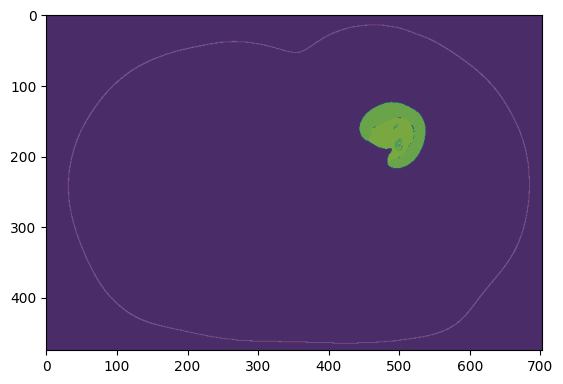

In [5]:
slice = 310
plt.imshow(test[0, :, :, slice])
bm = np.transpose(body_mask, (2, 0,1))
plt.imshow(bm[:,:, slice] * 1000, alpha=0.2, cmap='Reds_r')

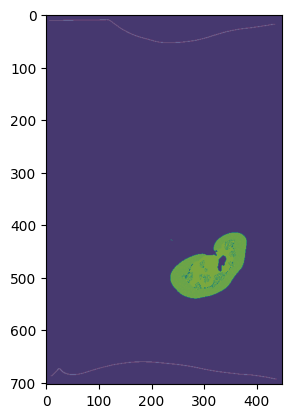

In [6]:
slice = 390
plt.imshow(test[0, 180, :, :])
bm = np.transpose(body_mask, (2, 0,1))
plt.imshow(bm[180,:, :] * 1000, alpha=0.2, cmap='Reds_r')

In [7]:
num_transducers = 1
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 3, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 0.5e6,
                                  elements = 64, 
                                  width = 40e-3,
                                  height =  40e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 3,
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 100e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

# place point at [50, 400, 350] on image; need to permute input to place_transducer_by_voxel because i built the .obj files in a dumb manner

pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[640,310,120], voxel_size[0])
pt = np.array([pt[2], pt[0], pt[1]])
normal = -np.array([normal[2] + 0.1, normal[0], normal[1]])




[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


In [8]:
pose = geometry.Transform.make_from_heading_vector(normal, pt)

theta = 0
about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0,0,0), about_axis=True)

transducer_pose = about_nl_axis * pose

test_transducer_set.assign_pose(0, transducer_pose)


In [9]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [11]:
test_sensor.visualize(test_phantom, 310)

TypeError: visualize() got an unexpected keyword argument 'vmax'

In [11]:
simprops = simulation.SimProperties(
                grid_size   = (180e-3,40e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [12]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [13]:
# test_experiment.plot_ray_path(0)

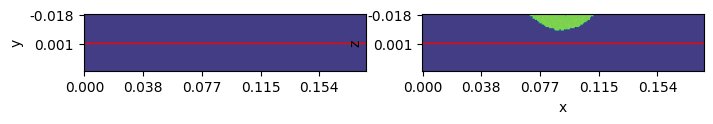

In [14]:
test_experiment.plot_ray_path(1)

In [15]:
# test_experiment.plot_ray_path(2)

In [16]:
test_experiment = experiment.Experiment.load('../experiment_files/kidney_experiment_01')
test_experiment.run(dry=True)

Number of simulation results (4) is greater than the expected number of simulation results (3), did the experiment parameters change since running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


In [17]:
test_experiment.run(repeat=True)

running with 3 workers



KeyboardInterrupt: 

preparation for sim    0 completed in           59.15 seconds

preparation for sim    2 completed in           59.25 seconds



┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                              256 x 96 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1715 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                              256 x 96 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1715 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:               NVIDIA RTX 6000 Ada Generation │
│ Number of CPU threads:                                     32 │
│ Processor name: AMD Ryzen Threadripper PRO 5955WX 16-Cores    │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                              256 x 96 x 96 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1715 │
├───────────────────────────────────────────────────────────────┤
│         